In [1]:
# Import all libraries for file and data manipulation
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
# Useful generic way to find whatever CSV file is in "data_raw" directory
data_dir = Path.cwd() / Path("data_raw")

for file_path in data_dir.glob("*.csv"):
    raw_data_path = data_dir / file_path.name
raw_data_path


WindowsPath('c:/Users/ARash/OneDrive/Portfolio/DataCrunching/housing-prediction-model/data_raw/housing.csv')

In [3]:
# Load CSV file dropping rows with nulls so that each column has the same non-null count
data = pd.read_csv(raw_data_path)
data = data.dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


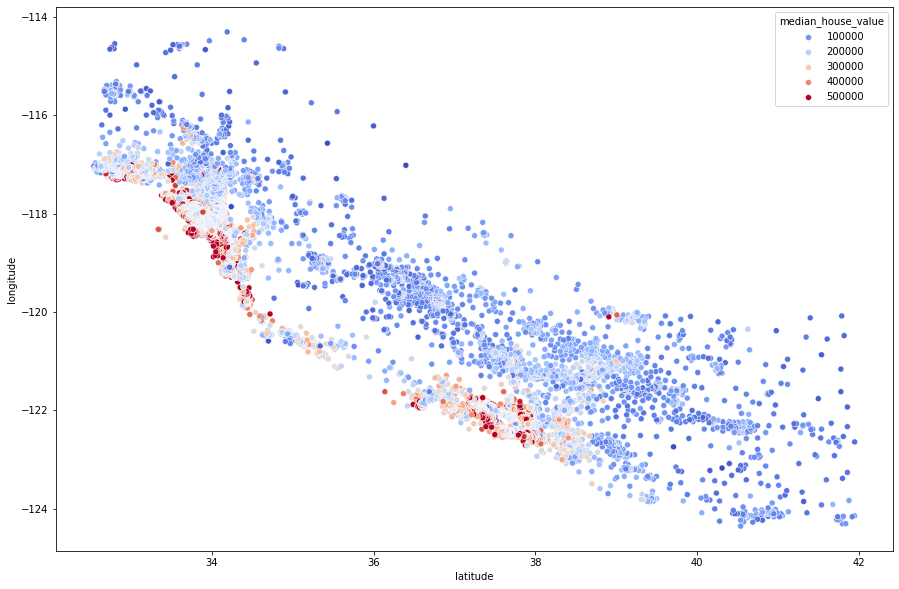

<Axes: xlabel='latitude', ylabel='longitude'>

In [4]:
# Now for a geographical visualization to see how this all comes together
plt.figure(figsize=(15,10))
sns.scatterplot(x="latitude", y="longitude", data=data, hue="median_house_value", palette="coolwarm")


As we can see above, the houses near the coast are higher priced, whereas the houses further inland are lower priced.

We see that the households and the rooms/bedrooms count are highly correlated. This implies that the ratio of bedrooms to rooms and rooms per household are also strong indicators of house value. Creating composite variables to glean more insight to what drives the target regressio is called "feature engineering."


In [5]:
# Create composite variables and draw heatmap to see new correlations
data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']
data['household_rooms'] = data['total_rooms'] / data['households']
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bedroom_ratio,household_rooms
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.146591,6.984127
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.155797,6.238137
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.129516,8.288136
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.184458,5.817352
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.172096,6.281853


In [6]:
# We have a categorical data column so let's see the different categories
data.ocean_proximity.value_counts()


ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [7]:
# Dumify categorical variables (in this case ocean_proximity) in place of x
# We cast the Bool to Int (numeric 0 or 1)
dumified = pd.get_dummies(data, dtype=int)
dumified.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedroom_ratio,household_rooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.146591,6.984127,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.155797,6.238137,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.129516,8.288136,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.184458,5.817352,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.172096,6.281853,0,0,0,1,0


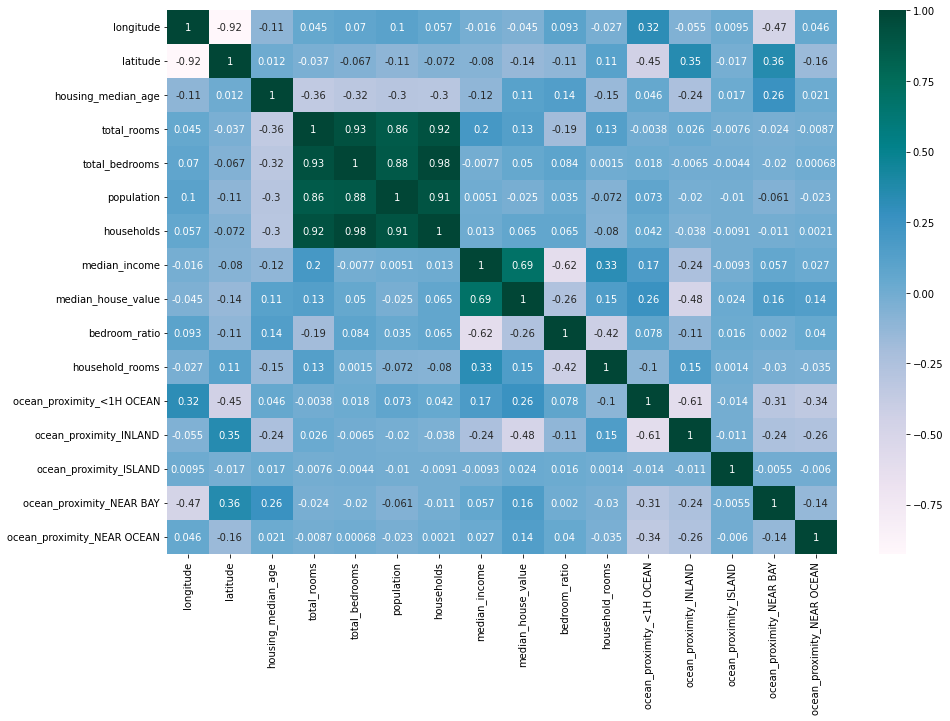

<Axes: >

In [8]:
plt.figure(figsize= (15, 10))
sns.heatmap(dumified.corr(), annot = True, cmap="PuBuGn")



The  heatmap above highlights the following:
 1. The most positive correlation variables are: median_income, <1H Ocean, Near Bay, and household_rooms.
 2. The most negative correlation variables are: Inland and bedroom_ratio.

# Now that data exploration is done, we move on to actually training the model.

In [9]:
# Separate the predictor *input* columns from the target *output* column
x = dumified.drop(['median_house_value'], axis=1)
y = dumified['median_house_value']


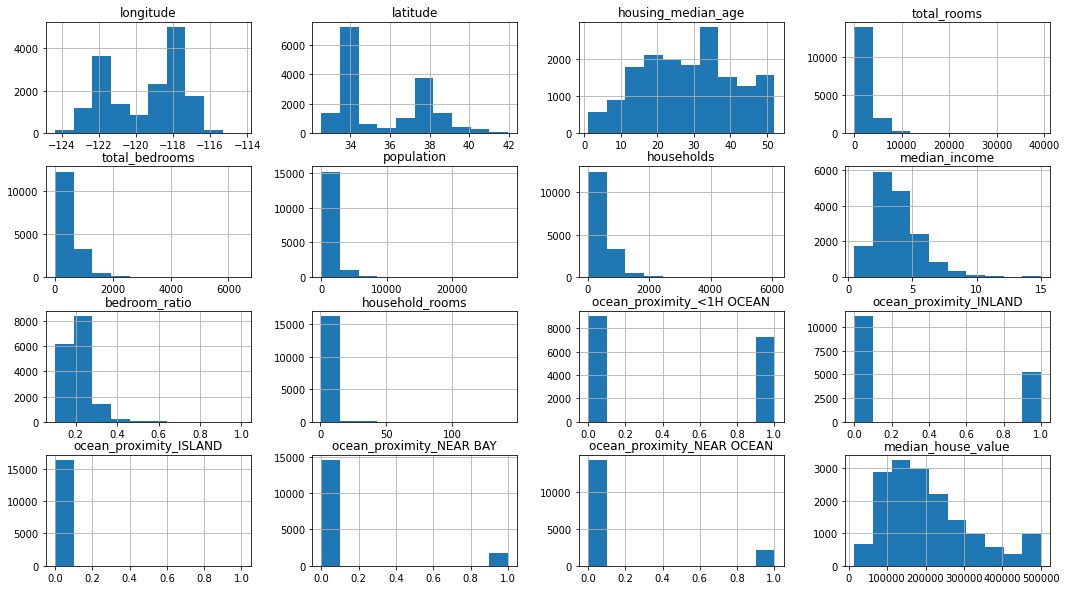

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'bedroom_ratio'}>,
        <Axes: title={'center': 'household_rooms'}>,
        <Axes: title={'center': 'ocean_proximity_<1H OCEAN'}>,
        <Axes: title={'center': 'ocean_proximity_INLAND'}>],
       [<Axes: title={'center': 'ocean_proximity_ISLAND'}>,
        <Axes: title={'center': 'ocean_proximity_NEAR BAY'}>,
        <Axes: title={'center': 'ocean_proximity_NEAR OCEAN'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

In [10]:
# Next we generate training data and explore its histogram
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
train_data = x_train.join(y_train)
train_data.hist(figsize = (18, 10))


# With trained model, we now see how well a linear regression fits the model

In [11]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)


LinearRegression()

In [12]:
# Investigate test data for evaluation
test_data = x_test.join(y_test)
test_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedroom_ratio,household_rooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
7693,-118.12,33.97,33.0,3099.0,839.0,2025.0,750.0,3.1830,0.270732,4.132000,1,0,0,0,0,191100.0
13209,-117.72,34.05,8.0,1841.0,409.0,1243.0,394.0,4.0614,0.222162,4.672589,0,1,0,0,0,107000.0
10232,-117.93,33.87,29.0,1221.0,371.0,1822.0,326.0,1.7935,0.303849,3.745399,1,0,0,0,0,162500.0
18856,-122.27,41.23,40.0,1958.0,386.0,725.0,331.0,2.1898,0.197140,5.915408,0,1,0,0,0,65500.0
6309,-117.99,34.04,30.0,4468.0,959.0,4027.0,938.0,3.1850,0.214637,4.763326,1,0,0,0,0,168300.0


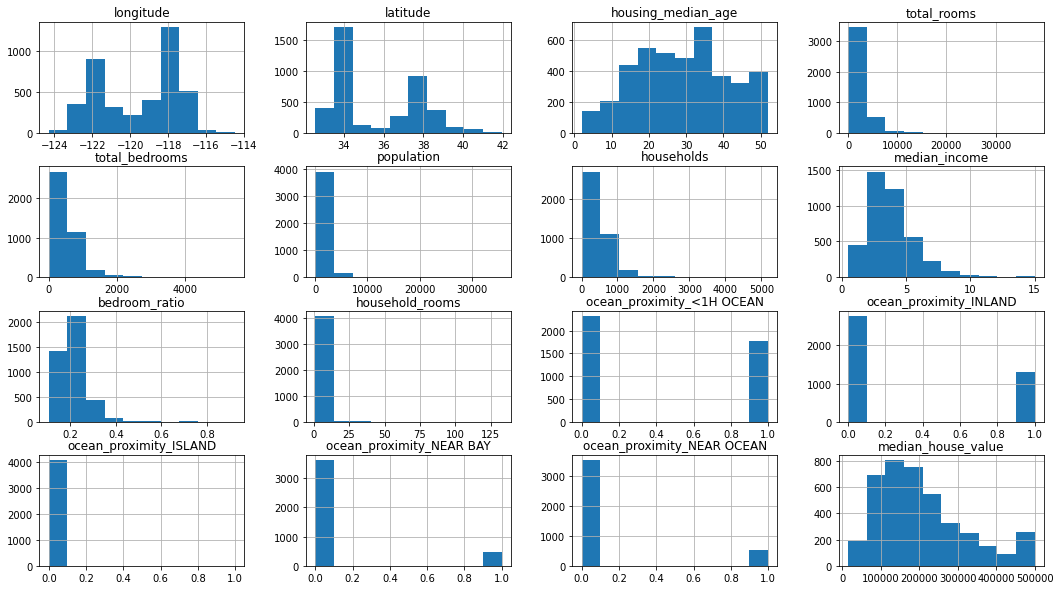

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'bedroom_ratio'}>,
        <Axes: title={'center': 'household_rooms'}>,
        <Axes: title={'center': 'ocean_proximity_<1H OCEAN'}>,
        <Axes: title={'center': 'ocean_proximity_INLAND'}>],
       [<Axes: title={'center': 'ocean_proximity_ISLAND'}>,
        <Axes: title={'center': 'ocean_proximity_NEAR BAY'}>,
        <Axes: title={'center': 'ocean_proximity_NEAR OCEAN'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

In [13]:
# Plot histogram of test data
test_data.hist(figsize = (18, 10))


In [14]:
# Evaluate our test score
reg.score(x_test,y_test)


0.6485379308485297

66% is not too bad, but it not good either.

# Now we see how well a random forest fits the model

In [15]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(x_train, y_train)


RandomForestRegressor()

In [16]:
forest.score(x_test, y_test)

0.8313068535944186

Random Forest is a much better model, with 83.13% being a decent predictor score.

# Finally we see how well a GridSearch fits the model

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [3, 10, 30],
    "max_features": [2, 4, 6, 8],
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [18]:
best_forest = grid_search.best_estimator_
best_forest.score(x_test, y_test)


0.8303819334985156

# Let us try different parameter tuning

In [19]:
param_grid2 = {
    "n_estimators": [30, 50, 80],
    "max_features": [8, 10, 14],
    "min_samples_split": [2, 4, 6]
}

grid_search2 = GridSearchCV(forest, param_grid2, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 10, 14],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [30, 50, 80]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
best_forest2 = grid_search2.best_estimator_
best_forest2.score(x_test, y_test)

0.8340542428057058

## In conclusion, the default Random Forest was the best model to predict median-house-value. While the GridSearchCV with parameter tuning was slightly better (83.41% vs 83.13%), the significantly higher computation time for GridSearchCV means the Random Forest was overall the optimal model for our use case.